In [73]:
from pathlib import Path
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, average_precision_score
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_curve, auc, roc_auc_score
from sklearn.preprocessing import label_binarize
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.calibration import calibration_curve
from sklearn.utils import resample
import matplotlib.pyplot as plt
import seaborn as sns

In [41]:
processed_data_dir = Path("data/processed")
interim_data_dir = Path("data/interim")

df = pd.read_csv(interim_data_dir / "02_data.csv")
print("Full preprocessed dataframe:", df.shape)
print(df.head())

X_train = pd.read_csv(processed_data_dir / "X_train.csv")
X_val   = pd.read_csv(processed_data_dir / "X_val.csv")
X_test  = pd.read_csv(processed_data_dir / "X_test.csv")

y_train = pd.read_csv(processed_data_dir / "y_train.csv").squeeze("columns")
y_val   = pd.read_csv(processed_data_dir / "y_val.csv").squeeze("columns")
y_test  = pd.read_csv(processed_data_dir / "y_test.csv").squeeze("columns")

X = pd.concat([X_train, X_val, X_test], axis=0).reset_index(drop=True)
y = pd.concat([y_train, y_val, y_test], axis=0).reset_index(drop=True)

print("Train split:", X_train.shape, y_train.shape)
print("Validation split:", X_val.shape, y_val.shape)
print("Test split:", X_test.shape, y_test.shape)
print("Full dataset:", X.shape, y.shape)

Full preprocessed dataframe: (54170, 26)
              DateTime  Consumption  Production  Nuclear  Wind  Hydroelectric  \
0  2019-01-01 00:00:00         6352        6527     1395    79           1383   
1  2019-01-01 01:00:00         6116        5701     1393    96           1112   
2  2019-01-01 02:00:00         5873        5676     1393   142           1030   
3  2019-01-01 03:00:00         5682        5603     1397   191            972   
4  2019-01-01 04:00:00         5557        5454     1393   159            960   

   Oil and Gas  Coal  Solar  Biomass  ...  demand_High  hour day_of_week  \
0         1896  1744      0       30  ...        False     0           1   
1         1429  1641      0       30  ...        False     1           1   
2         1465  1616      0       30  ...        False     2           1   
3         1455  1558      0       30  ...        False     3           1   
4         1454  1458      0       30  ...        False     4           1   

   month  hour_

In [5]:
svm = SVC(
    kernel="rbf",
    C=1.0,
    gamma=1,
    probability=True,
    random_state=42
)
svm.fit(X_train, y_train)

SVC(gamma=1, probability=True, random_state=42)

In [11]:
def basic_metrics(model, X_test, y_test):
    y_pred = model.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average="macro")
    recall = recall_score(y_test, y_pred, average="macro")
    f1 = f1_score(y_test, y_pred, average="macro")
    
    print(f"Accuracy:  {accuracy:.3f}")
    print(f"Precision: {precision:.3f}")
    print(f"Recall:    {recall:.3f}")  
    print(f"F1-Score:  {f1:.3f}")
    
    return y_pred

In [12]:
y_pred = basic_metrics(svm, X_test, y_test)


Accuracy:  0.723
Precision: 0.728
Recall:    0.723
F1-Score:  0.722


In [13]:
print(classification_report(y_test, y_pred, target_names=["Low", "Medium", "High"]))

              precision    recall  f1-score   support

         Low       0.84      0.71      0.77      3612
      Medium       0.62      0.61      0.61      3612
        High       0.73      0.84      0.78      3610

    accuracy                           0.72     10834
   macro avg       0.73      0.72      0.72     10834
weighted avg       0.73      0.72      0.72     10834



## Model Performance Interpretation

- **Accuracy (0.723)**  
  The model correctly classifies ~72% of all demand tier cases. This shows strong overall performance compared to the 33% random baseline, but accuracy alone may hide uneven performance across classes.

- **Precision (0.728)**  
  When the model predicts a given demand tier, it is correct about 73% of the time. This indicates relatively low false positives, which is valuable if misclassifying into a wrong demand tier could cause inefficient resource allocation.

- **Recall (0.723)**  
  The model successfully identifies ~72% of the actual demand cases across all classes. This means it captures most true events, but still misses ~28%. Recall is important if the cost of **failing to anticipate high demand** is high (e.g., risk of under-preparation for grid stress).

- **F1-Score (0.722)**  
  The harmonic mean of precision and recall shows a balanced trade-off between the two. This suggests the model is not biased toward one metric at the expense of the other.

---

## Business Alignment
For electricity demand classification:  
- **Recall** is most critical, especially for **High demand** cases, since missing these could cause under-preparedness and potential service issues.  
- **Precision** also matters, but a false alarm (predicting High when it’s actually Medium) is less costly than missing a real High demand event.  
- **Target metric:** **Macro Recall (or Macro F1)** should be prioritized to ensure all demand classes are well captured, with particular emphasis on High demand.

In [14]:
def plot_confusion_matrix(y_test, y_pred):
    """Create clear confusion matrix visualization"""
    cm = confusion_matrix(y_test, y_pred)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    
    # Simple analysis
    total = cm.sum()
    accuracy = (cm[0,0] + cm[1,1]) / total
    print(f"Total samples: {total}")
    print(f"Accuracy: {accuracy:.3f}")
    
    return cm

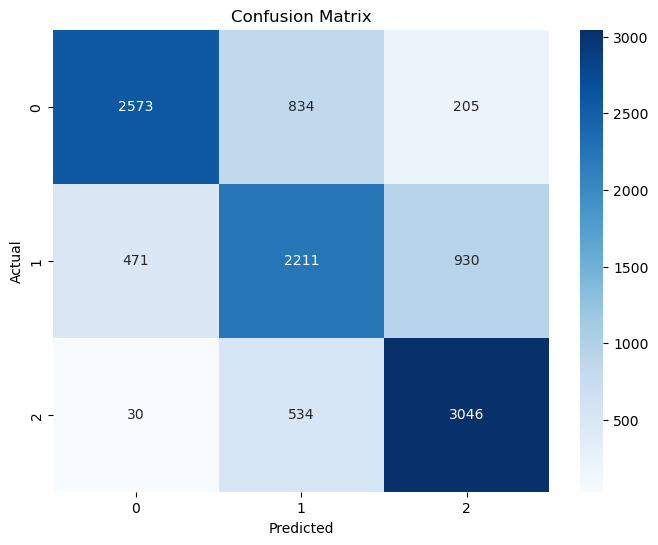

Total samples: 10834
Accuracy: 0.442


array([[2573,  834,  205],
       [ 471, 2211,  930],
       [  30,  534, 3046]])

In [15]:
plot_confusion_matrix(y_test, y_pred)

## Error Patterns & Business Impact

### 1. Low Demand
- **Precision: 0.84** → Most predicted Lows are correct.
- **Recall: 0.71** → 29% of true Lows are misclassified (often as Medium).
- **Error Pattern:** Underestimation risk is modest. Missing Low demand is not critical but may reduce efficiency (e.g., over-preparing when demand is actually low).

### 2. Medium Demand
- **Precision: 0.62, Recall: 0.61** → Roughly 40% of Mediums are misclassified.
- **Error Pattern:** Medium demand is the hardest class, often confused with Low or High.
- **Business Impact:** Medium is less operationally critical, but misclassifications reduce trust in the system and may blur insights for demand planning.

### 3. High Demand
- **Precision: 0.73, Recall: 0.84** → The model captures most true Highs (good), but ~27% of predicted Highs are false alarms.
- **Error Pattern:** Tendency to over-predict High demand.
- **Business Impact:**
  - **False Negative (High → Medium/Low):** Most costly, as under-preparedness risks grid stress or outages.
  - **False Positive (Medium/Low → High):** Less costly, as over-preparing increases resource allocation but maintains safety.

---

## Business Impact by Cost Assumption

1. **Conservative Scenario (Safety First)**  
   - Assign **high penalty to false negatives in High demand**.  
   - Current recall of 0.84 means the model misses ~16% of true Highs → potentially critical.  

2. **Efficiency Scenario (Minimize Waste)**  
   - Assign **higher penalty to false positives in High demand**.  
   - Precision of 0.73 means ~27% of High predictions trigger unnecessary resource allocation.  

3. **Balanced Scenario**  
   - Optimize for **macro F1 (0.72)** to balance overall cost across classes.  
   - Medium class errors remain a secondary concern compared to High demand.  

---

## Conclusion
- **Most problematic error:** Misclassifying true High demand as Medium/Low (false negatives).  
- **Business priority:** Improve High demand recall beyond 0.90, even at the expense of slightly lower precision.  
- **Next step:** Engineer features (lags, holidays, external factors) that help distinguish **High vs Medium**, while accepting some false alarms to protect reliability of grid operations.

In [21]:
labels = ["Low", "Medium", "High"]

def multiclass_roc_analysis(model, X_test, y_test, class_names=None):
    """Multiclass ROC curve analysis (One-vs-Rest)"""
    # Predict probabilities
    y_proba = model.predict_proba(X_test)
    
    # Binarize true labels
    classes = np.unique(y_test)
    y_test_bin = label_binarize(y_test, classes=classes)
    
    # Plot setup
    plt.figure(figsize=(8, 6))
    
    roc_aucs = {}
    for i, cls in enumerate(classes):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_proba[:, i])
        roc_auc = auc(fpr, tpr)
        roc_aucs[cls] = roc_auc
        
        label = f"{class_names[i] if class_names is not None else cls} (AUC = {roc_auc:.3f})"
        plt.plot(fpr, tpr, lw=2, label=label)
    
    # Chance line
    plt.plot([0, 1], [0, 1], "k--", lw=2, label="Random Classifier")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Multiclass ROC Curve")
    plt.legend(loc="lower right")
    plt.show()
    
    # Macro-average AUC
    macro_auc = roc_auc_score(y_test_bin, y_proba, average="macro", multi_class="ovr")
    
    return roc_aucs, macro_auc

def interpret_auc(auc_score):
    """Simple AUC interpretation"""
    if auc_score >= 0.9:
        return "Excellent model"
    elif auc_score >= 0.8:
        return "Good model"
    elif auc_score >= 0.7:
        return "Fair model"
    elif auc_score >= 0.6:
        return "Poor model"
    else:
        return "Random performance"

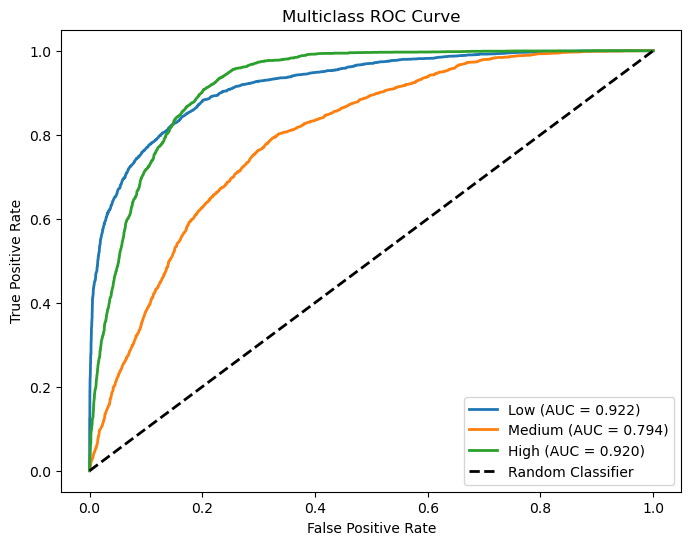

Model Assessment: Good model


In [23]:
roc_aucs, macro_auc = multiclass_roc_analysis(svm, X_test, y_test, labels)
print(f"Model Assessment: {interpret_auc(macro_auc)}")

In [28]:
def multiclass_pr_analysis(model, X_test, y_test, class_names=None):
    """Multiclass Precision-Recall analysis (One-vs-Rest)"""
    # Predict probabilities
    y_proba = model.predict_proba(X_test)
    
    # Binarize true labels
    classes = np.unique(y_test)
    y_test_bin = label_binarize(y_test, classes=classes)
    
    plt.figure(figsize=(8, 6))
    pr_aucs = {}
    
    for i, cls in enumerate(classes):
        precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_proba[:, i])
        pr_auc = average_precision_score(y_test_bin[:, i], y_proba[:, i])
        pr_aucs[cls] = pr_auc
        
        label = f"{class_names[i] if class_names is not None else cls} (AP = {pr_auc:.3f})"
        plt.plot(recall, precision, lw=2, label=label)
    
    # Micro-average curve (aggregated over all classes)
    precision, recall, _ = precision_recall_curve(y_test_bin.ravel(), y_proba.ravel())
    micro_auc = average_precision_score(y_test_bin, y_proba, average="micro")
    plt.plot(recall, precision, lw=2, linestyle="--", 
             label=f"Micro-average (AP = {micro_auc:.3f})")
    
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Multiclass Precision-Recall Curve")
    plt.legend(loc="lower left")
    plt.show()
    
    # Macro-average AUC
    macro_auc = average_precision_score(y_test_bin, y_proba, average="macro")
    
    return pr_aucs, micro_auc, macro_auc

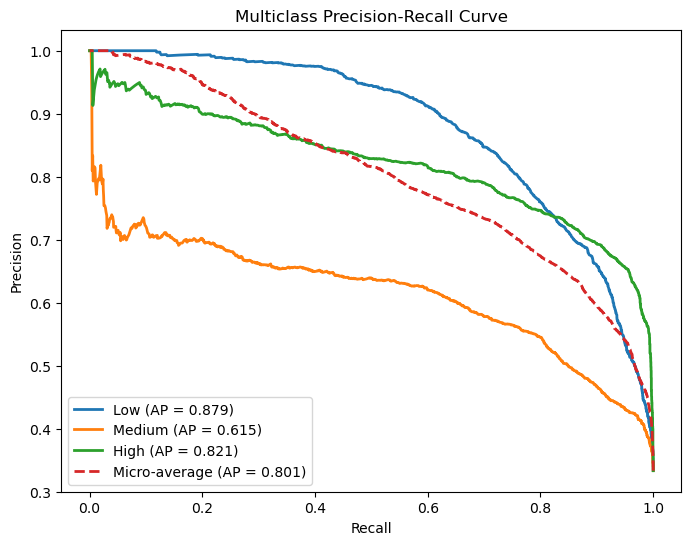

({np.int64(0): np.float64(0.8788263220600991),
  np.int64(1): np.float64(0.6151641443343163),
  np.int64(2): np.float64(0.821008664360214)},
 np.float64(0.801186758526353),
 np.float64(0.7716663769182098))

In [29]:
multiclass_pr_analysis(svm, X_test, y_test, labels)

In [30]:
def choose_curve_type(y_test):
    """Decide which curve is more informative"""
    positive_rate = y_test.mean()
    
    if positive_rate < 0.1:
        return "Use Precision-Recall: Highly imbalanced dataset"
    elif positive_rate < 0.3:
        return "Use both curves: Moderately imbalanced"
    else:
        return "ROC sufficient: Relatively balanced classes"

In [31]:
choose_curve_type(y_test)

'ROC sufficient: Relatively balanced classes'

In [36]:
def find_best_threshold_multiclass(model, X_test, y_test, target_precision=0.8, class_names=None):
    """
    Find per-class thresholds for desired precision (One-vs-Rest).
    
    Args:
        model: trained classifier with predict_proba
        X_test, y_test: test features and labels
        target_precision: precision target (e.g., 0.8)
        class_names: optional list of class names for readability
    """
    # Predict probabilities
    y_proba = model.predict_proba(X_test)
    classes = np.unique(y_test)
    y_test_bin = label_binarize(y_test, classes=classes)

    thresholds_dict = {}

    for i, cls in enumerate(classes):
        precision, recall, thresholds = precision_recall_curve(y_test_bin[:, i], y_proba[:, i])
        
        best_threshold = None
        achieved_recall = None
        for p, r, t in zip(precision, recall, np.append(thresholds, 1.0)):  # thresholds shorter by 1
            if p >= target_precision:
                best_threshold = t
                achieved_recall = r
                break

        label = class_names[i] if class_names is not None else cls
        if best_threshold is not None:
            print(f"[{label}] To reach {target_precision:.1%} precision → "
                  f"Threshold: {best_threshold:.3f}, Recall: {achieved_recall:.3f}")
            thresholds_dict[label] = (best_threshold, achieved_recall)
        else:
            print(f"[{label}] Cannot reach {target_precision:.1%} precision")
            thresholds_dict[label] = None

    return thresholds_dict

In [37]:
find_best_threshold_multiclass(svm, X_test, y_test, target_precision=0.8, class_names=labels)

[Low] To reach 80.0% precision → Threshold: 0.377, Recall: 0.760
[Medium] To reach 80.0% precision → Threshold: 0.782, Recall: 0.020
[High] To reach 80.0% precision → Threshold: 0.738, Recall: 0.651


{'Low': (np.float64(0.37664092919726977), np.float64(0.7599667774086378)),
 'Medium': (np.float64(0.781858456069346), np.float64(0.019933554817275746)),
 'High': (np.float64(0.737788408459928), np.float64(0.6509695290858726))}

In [39]:
def reliable_cv_evaluation(model, X, y):
    """Simple but robust cross-validation"""
    # Use stratified k-fold for balanced splits
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    # Test multiple metrics
    accuracy_scores = cross_val_score(model, X, y, cv=cv, scoring='accuracy')
    f1_scores = cross_val_score(model, X, y, cv=cv, scoring='f1_weighted')
    
    print("Cross-Validation Results:")
    print(f"Accuracy: {accuracy_scores.mean():.3f} ± {accuracy_scores.std():.3f}")
    print(f"F1-Score: {f1_scores.mean():.3f} ± {f1_scores.std():.3f}")
    
    # Check consistency
    if accuracy_scores.std() > 0.05:
        print("⚠️ High variance - model performance is inconsistent")
    else:
        print("✅ Stable performance across folds")
    
    return accuracy_scores, f1_scores

In [42]:
reliable_cv_evaluation(svm, X, y)

Cross-Validation Results:
Accuracy: 0.724 ± 0.001
F1-Score: 0.723 ± 0.001
✅ Stable performance across folds


(array([0.72521691, 0.72254015, 0.72207864, 0.72558612, 0.72263245]),
 array([0.72398007, 0.72323615, 0.72215552, 0.72503295, 0.72286291]))

In [43]:
def analyze_errors(model, X_test, y_test):
    """Find patterns in model errors"""
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)
    
    # Identify errors
    errors = (y_test != y_pred)
    
    print(f"Error Rate: {errors.mean():.3f}")
    print(f"Total Errors: {errors.sum()} / {len(y_test)}")
    
    # Confidence analysis
    max_confidence = y_proba.max(axis=1)
    correct_confidence = max_confidence[~errors].mean()
    error_confidence = max_confidence[errors].mean()
    
    print(f"Average confidence (correct): {correct_confidence:.3f}")
    print(f"Average confidence (errors): {error_confidence:.3f}")
    
    # Low confidence predictions
    low_confidence = max_confidence < 0.6
    print(f"Low confidence predictions: {low_confidence.sum()} ({low_confidence.mean():.1%})")

In [44]:
analyze_errors(svm, X_test, y_test)

Error Rate: 0.277
Total Errors: 3004 / 10834
Average confidence (correct): 0.773
Average confidence (errors): 0.686
Low confidence predictions: 1435 (13.2%)


In [45]:
def feature_error_patterns(X_test, y_test, y_pred, top_features):
    """Analyze how features relate to errors"""
    errors = (y_test != y_pred)
    
    print("Feature Analysis for Errors:")
    for feature in top_features[:3]:  # Top 3 features
        correct_mean = X_test[feature][~errors].mean()
        error_mean = X_test[feature][errors].mean()
        
        print(f"\n{feature}:")
        print(f"  Correct predictions: {correct_mean:.3f}")
        print(f"  Error predictions: {error_mean:.3f}")
        print(f"  Difference: {abs(correct_mean - error_mean):.3f}")

In [46]:
features = [
    "hour_sin",
    "hour_cos",
    "dow_sin",
    "month_cos",
    "dow_cos",
    "month_sin"
]
feature_error_patterns(X_test, y_test, y_pred, features)

Feature Analysis for Errors:

hour_sin:
  Correct predictions: 0.020
  Error predictions: -0.045
  Difference: 0.064

hour_cos:
  Correct predictions: 0.047
  Error predictions: -0.124
  Difference: 0.171

dow_sin:
  Correct predictions: 0.019
  Error predictions: -0.015
  Difference: 0.033


In [47]:
def confidence_strategy(model, X_test, confidence_threshold=0.8):
    """Design confidence-based business strategy"""
    y_proba = model.predict_proba(X_test)
    max_confidence = y_proba.max(axis=1)
    
    high_confidence = max_confidence >= confidence_threshold
    low_confidence = max_confidence < confidence_threshold
    
    print(f"Business Strategy (threshold: {confidence_threshold}):")
    print(f"Auto-process: {high_confidence.sum()} samples ({high_confidence.mean():.1%})")
    print(f"Manual review: {low_confidence.sum()} samples ({low_confidence.mean():.1%})")
    print(f"Workload reduction: {high_confidence.mean():.1%}")

In [48]:
confidence_strategy(svm, X_test, confidence_threshold=0.8)

Business Strategy (threshold: 0.8):
Auto-process: 3258 samples (30.1%)
Manual review: 7576 samples (69.9%)
Workload reduction: 30.1%


In [ ]:
def check_calibration_multiclass(model, X_test, y_test, class_names=None, n_bins=10):
    """
    Multiclass calibration analysis (One-vs-Rest).
    
    Plots calibration curves for each class separately.
    """
    y_proba = model.predict_proba(X_test)
    classes = np.unique(y_test)
    
    plt.figure(figsize=(8, 6))
    for i, cls in enumerate(classes):
        # Binary labels for this class vs rest
        y_true_bin = (y_test == cls).astype(int)
        prob_true, prob_pred = calibration_curve(y_true_bin, y_proba[:, i], n_bins=n_bins)
        
        label = class_names[i] if class_names is not None else str(cls)
        plt.plot(prob_pred, prob_true, marker="s", lw=2, label=f"{label}")
    
    # Reference line
    plt.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
    plt.xlabel("Mean Predicted Probability")
    plt.ylabel("Fraction of Positives")
    plt.title("Calibration Curves (One-vs-Rest)")
    plt.legend()
    plt.show()
    
    # Compute calibration errors per class
    calibration_errors = {}
    for i, cls in enumerate(classes):
        y_true_bin = (y_test == cls).astype(int)
        prob_true, prob_pred = calibration_curve(y_true_bin, y_proba[:, i], n_bins=n_bins)
        calibration_error = abs(prob_true - prob_pred).mean()
        print(f"Calibration Error for '{cls}': {calibration_error:.3f}")
        if calibration_error < 0.05:
            print("✅ Well calibrated")
        elif calibration_error < 0.1:
            print("⚠️ Reasonably calibrated")
        else:
            print("🔴 Poorly calibrated")
        calibration_errors[cls] = calibration_error
    
    return calibration_errors

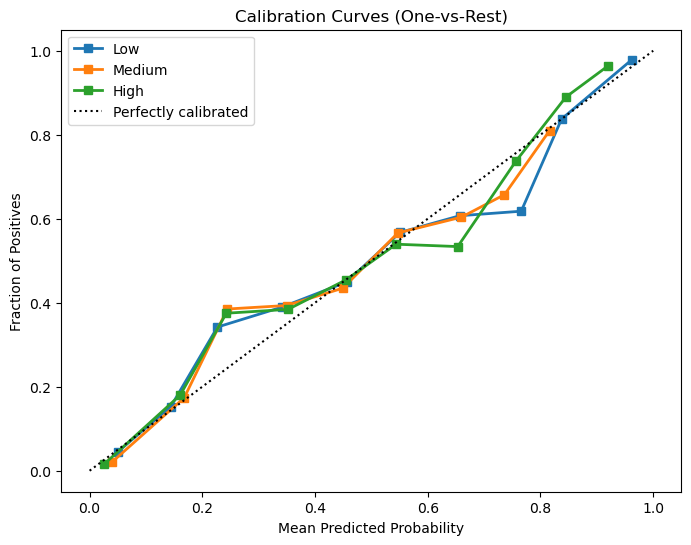

Calibration Error for '0': 0.042
✅ Well calibrated
Calibration Error for '1': 0.043
✅ Well calibrated
Calibration Error for '2': 0.043
✅ Well calibrated


{np.int64(0): np.float64(0.041528373876860765),
 np.int64(1): np.float64(0.042719298439132296),
 np.int64(2): np.float64(0.04267630591565994)}

In [55]:
check_calibration_multiclass(svm, X_test, y_test, class_names=labels, n_bins=10)

In [56]:
def analyze_feature_importance(model, feature_names):
    """Extract and analyze feature importance"""
    
    # Method 1: Built-in importance (for tree-based models)
    if hasattr(model, 'feature_importances_'):
        importance = model.feature_importances_
        method = "Built-in importance"
    elif hasattr(model, 'coef_'):
        importance = abs(model.coef_[0])
        method = "Coefficient magnitude"
    else:
        print("Model doesn't have built-in feature importance")
        return None
    
    # Create importance ranking
    feature_importance = list(zip(feature_names, importance))
    feature_importance.sort(key=lambda x: x[1], reverse=True)
    
    print(f"Feature Importance ({method}):")
    for i, (feature, imp) in enumerate(feature_importance[:10]):
        print(f"{i+1:2d}. {feature}: {imp:.4f}")
    
    return feature_importance

In [57]:
analyze_feature_importance(svm, feature_names=features)

Model doesn't have built-in feature importance


In [59]:
def bootstrap_confidence_intervals(model, X_test, y_test, n_bootstrap=1000):
    """Calculate confidence intervals for performance metrics"""
    
    bootstrap_scores = []
    
    for i in range(n_bootstrap):
        # Bootstrap sample
        X_boot, y_boot = resample(X_test, y_test, random_state=i)
        
        # Calculate metric
        y_pred_boot = model.predict(X_boot)
        score = accuracy_score(y_boot, y_pred_boot)
        bootstrap_scores.append(score)
    
    # Calculate confidence intervals
    confidence_level = 0.95
    alpha = 1 - confidence_level
    lower = np.percentile(bootstrap_scores, (alpha/2) * 100)
    upper = np.percentile(bootstrap_scores, (1 - alpha/2) * 100)
    mean_score = np.mean(bootstrap_scores)
    
    print(f"Bootstrap Confidence Interval ({confidence_level:.0%}):")
    print(f"Mean Accuracy: {mean_score:.3f}")
    print(f"95% CI: [{lower:.3f}, {upper:.3f}]")
    
    return mean_score, (lower, upper)

In [60]:
bootstrap_confidence_intervals(svm, X_test, y_test, n_bootstrap=1000)

Bootstrap Confidence Interval (95%):
Mean Accuracy: 0.723
95% CI: [0.714, 0.731]


(np.float64(0.7226682665682111),
 (np.float64(0.713861454679712), np.float64(0.7309396344840318)))

In [ ]:
rf = RandomForestClassifier(
        n_estimators=100,      # Number of trees
        max_depth=10,          # Maximum depth per tree
        min_samples_split=20,  # Minimum samples to split
        min_samples_leaf=5,    # Minimum samples per leaf
        max_features='sqrt',   # Features per split
        bootstrap=True,        # Use bootstrap sampling
        random_state=42,
        n_jobs=-1             # Use all processors
    )
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, min_samples_leaf=5, min_samples_split=20,
                       n_jobs=-1, random_state=42)

In [71]:
def analyze_model_performance(model, X_test, y_test):
    y_pred = basic_metrics(model, X_test, y_test)
    print(classification_report(y_test, y_pred, target_names=labels))
    plot_confusion_matrix(y_test, y_pred)
    roc_aucs, macro_auc = multiclass_roc_analysis(model, X_test, y_test, labels)
    print(f"Model Assessment: {interpret_auc(macro_auc)}")
    multiclass_pr_analysis(model, X_test, y_test, labels)
    find_best_threshold_multiclass(model, X_test, y_test, target_precision=0.8, class_names=labels)
    reliable_cv_evaluation(model, X, y)
    analyze_errors(model, X_test, y_test)
    feature_error_patterns(X_test, y_test, y_pred, features)
    confidence_strategy(model, X_test, confidence_threshold=0.8)
    check_calibration_multiclass(model, X_test, y_test, class_names=labels, n_bins=10)
    analyze_feature_importance(model, feature_names=features)
    bootstrap_confidence_intervals(model, X_test, y_test, n_bootstrap=1000)

Accuracy:  0.718
Precision: 0.720
Recall:    0.718
F1-Score:  0.717
              precision    recall  f1-score   support

         Low       0.82      0.73      0.77      3612
      Medium       0.61      0.59      0.60      3612
        High       0.73      0.83      0.78      3610

    accuracy                           0.72     10834
   macro avg       0.72      0.72      0.72     10834
weighted avg       0.72      0.72      0.72     10834



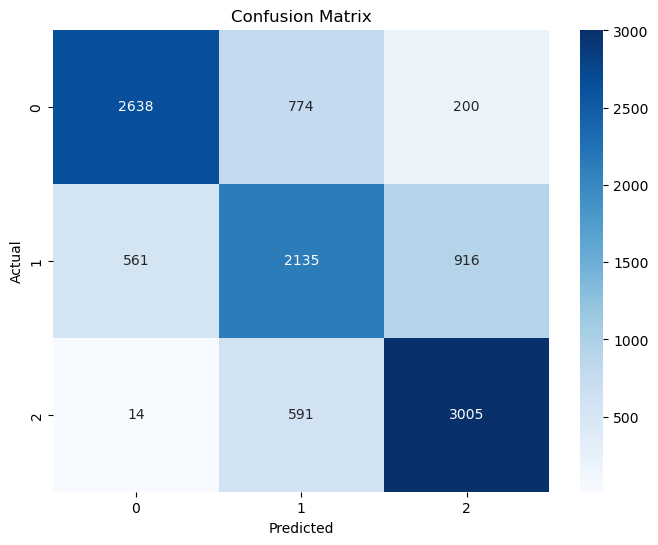

Total samples: 10834
Accuracy: 0.441


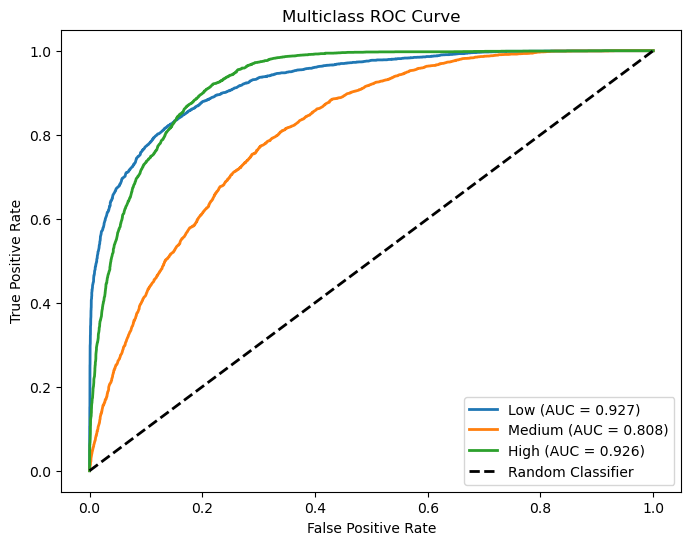

Model Assessment: Good model


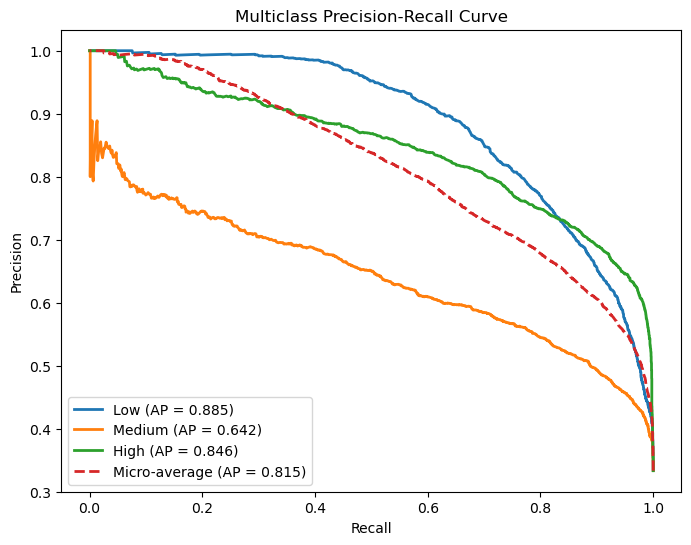

[Low] To reach 80.0% precision → Threshold: 0.434, Recall: 0.766
[Medium] To reach 80.0% precision → Threshold: 0.771, Recall: 0.062
[High] To reach 80.0% precision → Threshold: 0.578, Recall: 0.705
Cross-Validation Results:
Accuracy: 0.718 ± 0.003
F1-Score: 0.717 ± 0.002
✅ Stable performance across folds
Error Rate: 0.282
Total Errors: 3056 / 10834
Average confidence (correct): 0.750
Average confidence (errors): 0.607
Low confidence predictions: 3598 (33.2%)
Feature Analysis for Errors:

hour_sin:
  Correct predictions: 0.017
  Error predictions: -0.036
  Difference: 0.053

hour_cos:
  Correct predictions: 0.052
  Error predictions: -0.132
  Difference: 0.184

dow_sin:
  Correct predictions: 0.020
  Error predictions: -0.018
  Difference: 0.038
Business Strategy (threshold: 0.8):
Auto-process: 3723 samples (34.4%)
Manual review: 7111 samples (65.6%)
Workload reduction: 34.4%


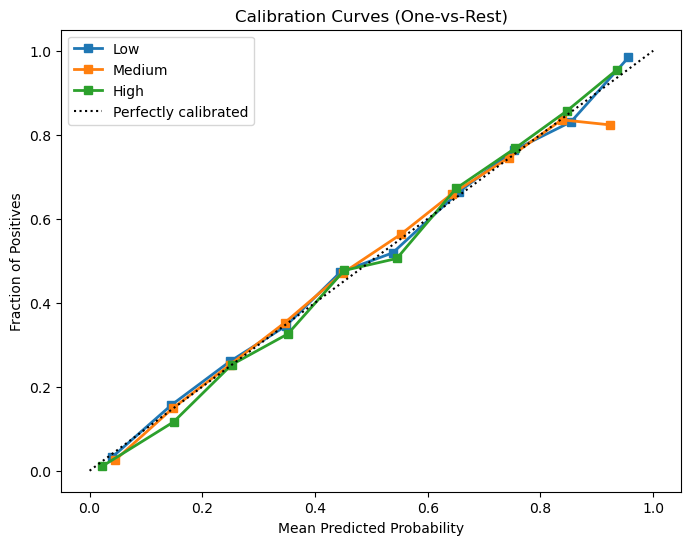

Calibration Error for '0': 0.015
✅ Well calibrated
Calibration Error for '1': 0.018
✅ Well calibrated
Calibration Error for '2': 0.020
✅ Well calibrated
Feature Importance (Built-in importance):
 1. hour_cos: 0.2873
 2. hour_sin: 0.2666
 3. dow_sin: 0.1585
 4. month_sin: 0.1552
 5. dow_cos: 0.0940
 6. month_cos: 0.0383
Bootstrap Confidence Interval (95%):
Mean Accuracy: 0.718
95% CI: [0.709, 0.726]


In [72]:
analyze_model_performance(rf, X_test, y_test)

# SVM vs Random Forest – Per-Class Performance

| Class   | Model         | Precision | Recall | F1-Score |
|---------|---------------|-----------|--------|----------|
| **Low** | SVM           | **0.84**  | 0.71   | 0.77     |
|         | Random Forest | 0.82      | **0.73** | 0.77   |
| **Medium** | SVM        | 0.62      | **0.61** | **0.61** |
|         | Random Forest | 0.61      | 0.59   | 0.60     |
| **High** | SVM          | 0.73      | **0.84** | 0.78   |
|         | Random Forest | 0.73      | 0.83   | 0.78     |

---

## Quick Insights
- **Low demand:** SVM better precision, Random Forest better recall → trade-off, overall F1 same.  
- **Medium demand:** Both weak, SVM slightly ahead (0.61 vs 0.60 F1).  
- **High demand:** Nearly identical, SVM has a slight edge on recall (0.84 vs 0.83).  

Both models deliver **~0.72 accuracy and macro F1**, but SVM edges ahead slightly in critical High demand recall.

# Model Performance Comparison – SVM vs Random Forest

## Support Vector Machine (SVM)
- **Accuracy:** 0.72  
- **Macro F1:** 0.72  
- **Per-class performance:**
  - *Low:* Precision 0.84, Recall 0.71, F1 0.77  
  - *Medium:* Precision 0.62, Recall 0.61, F1 0.61  
  - *High:* Precision 0.73, Recall 0.84, F1 0.78  
- **Strengths:** Excellent recall for High demand (0.84), making it reliable for catching critical peaks.  
- **Weaknesses:** Medium demand is the hardest to separate (precision/recall ~0.61).  

## Random Forest
- **Accuracy:** 0.718  
- **Macro F1:** 0.717  
- **Per-class performance:**
  - *Low:* Precision 0.82, Recall 0.73, F1 0.77  
  - *Medium:* Precision 0.61, Recall 0.59, F1 0.60  
  - *High:* Precision 0.73, Recall 0.83, F1 0.78  
- **Strengths:** Balanced performance across all classes, slightly better recall for Low demand compared to SVM.  
- **Weaknesses:** Medium demand remains problematic; slightly lower overall metrics than SVM.  

## Comparison
- Both models are **very close** (~72% accuracy, ~0.72 macro F1).  
- **SVM** edges out with slightly higher overall precision/recall, especially in **High demand recall (0.84 vs 0.83)**.  
- **Random Forest** is more interpretable and offers marginally better **Low demand recall (0.73 vs 0.71)**.  
- Both struggle equally with the **Medium demand class**.  

## Recommendation
- Use **SVM** when the priority is **maximizing recall for High demand** (avoiding under-preparedness).  
- Use **Random Forest** when **interpretability** or stakeholder trust in feature importance is required.  
- Next step: test **boosted trees (XGBoost, LightGBM)** to combine interpretability with stronger non-linear performance and potentially improve Medium demand classification.